In [1]:
%run lgs03a_data_unification.ipynb

In [2]:
from matplotlib.lines import Line2D

# Correlation of mutation effects across genes

Neutral/near-neutral mutations tends to stay neutral, and lethal ones stay lethal, but no correlation between the effects of mutations in different backgrounds beyond that.

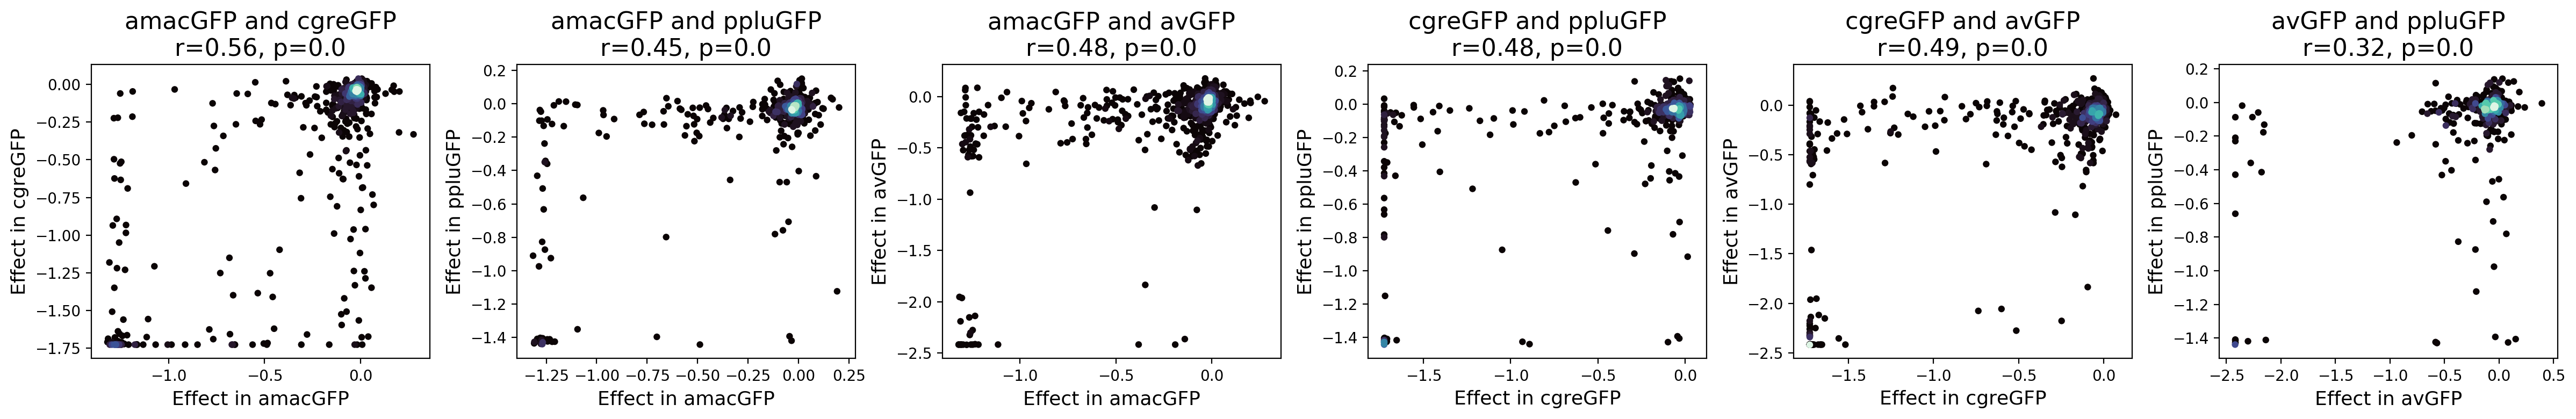

In [3]:
axes = subplots(nplots=6, nplots_per_row=6)
gene_pairs = [('amac','cgre'),('amac','pplu'),('amac','av'),('cgre','pplu'),('cgre','av'),('av','pplu')]

for ax,pair in zip(axes, gene_pairs):
    a = df_effects_singles['effect_in_'+pair[0]]
    b = df_effects_singles['effect_in_'+pair[1]]
    corr = scipy.stats.spearmanr(a,b, nan_policy='omit')
    plt.sca(ax)
    density_plot(np.array(a), np.array(b), s=20, cmap='mako')
    label_plot_axis(x = 'Effect in %sGFP' % pair[0], y = 'Effect in %sGFP' % pair[1],
                   t = '%sGFP and %sGFP\nr=%s, p=%s' % (pair[0], pair[1], round(corr[0],2), round(corr[1], 5)))
    
plt.tight_layout()

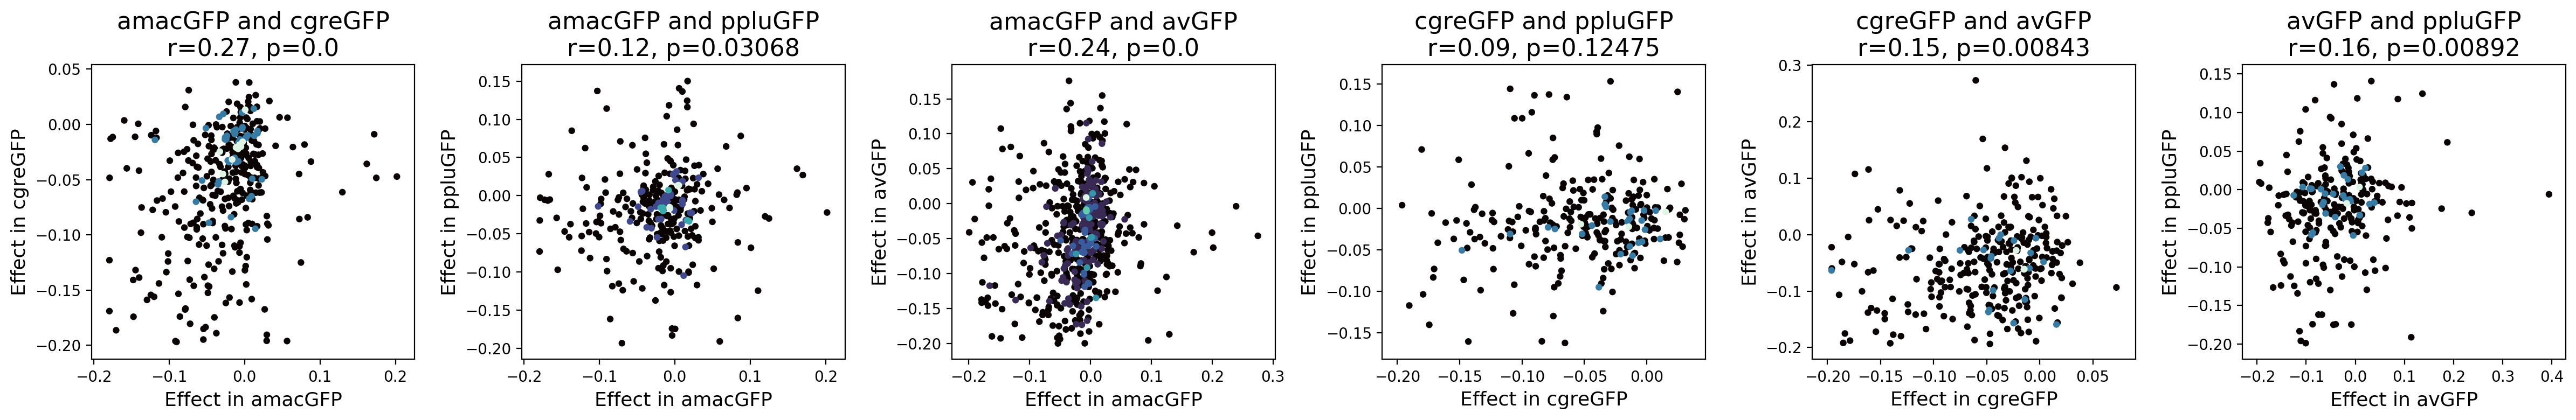

In [4]:
axes = subplots(nplots=6, nplots_per_row=6)
gene_pairs = [('amac','cgre'),('amac','pplu'),('amac','av'),('cgre','pplu'),('cgre','av'),('av','pplu')]

for ax,pair in zip(axes, gene_pairs):
    a = df_effects_singles[(df_effects_singles['effect_in_'+pair[0]]>-0.2) &
                          (df_effects_singles['effect_in_'+pair[1]]>-0.2)]['effect_in_'+pair[0]]
    b = df_effects_singles[(df_effects_singles['effect_in_'+pair[0]]>-0.2) &
                          (df_effects_singles['effect_in_'+pair[1]]>-0.2)]['effect_in_'+pair[1]]
    corr = scipy.stats.spearmanr(a,b, nan_policy='omit')
    plt.sca(ax)
    density_plot(np.array(a), np.array(b), s=20, cmap='mako')
    label_plot_axis(x = 'Effect in %sGFP' % pair[0], y = 'Effect in %sGFP' % pair[1],
                   t = '%sGFP and %sGFP\nr=%s, p=%s' % (pair[0], pair[1], round(corr[0],2), round(corr[1], 5)))
    
plt.tight_layout()

# Mutations which change effect across genes

In [5]:
stds = {'amac' : 0.03148308406723709, 'cgre' : 0.02852658185221242, 'pplu' : 0.027489382693326424,
          'amacV14L' : 0.029670382945273337, 'av' : 0.0817635644945253}

In [7]:
def hm_neutrality(gene1, gene2, neutral_threshold, bad_threshold,):
    df = df_effects_singles[['effect_in_'+gene1, 'effect_in_'+gene2]].dropna() # muts must be obsered in both genes
    df = df.reset_index()
    
    neutral_in_gene1 = set(df[df[f'effect_in_{gene1}'] > -stds[gene1]*neutral_threshold].index)
    neutral_in_gene2 = set(df[df[f'effect_in_{gene2}'] > -stds[gene2]*neutral_threshold].index)
    bad_in_gene1 = set(df[df[f'effect_in_{gene1}'] < -stds[gene1]*bad_threshold].index)
    bad_in_gene2 = set(df[df[f'effect_in_{gene2}'] < -stds[gene2]*bad_threshold].index)
        
    dfmuts = pd.DataFrame()
    dfmuts.loc[f'Neutral\nin {gene1}', f'Neutral\nin {gene2}'] = len(neutral_in_gene1 & neutral_in_gene2)
    dfmuts.loc[f'Neutral\nin {gene1}', f'Deleterious\nin {gene2}'] = len(neutral_in_gene1 & bad_in_gene2)
    dfmuts.loc[f'Deleterious\nin {gene1}', f'Neutral\nin {gene2}'] = len(bad_in_gene1 & neutral_in_gene2)
    dfmuts.loc[f'Deleterious\nin {gene1}', f'Deleterious\nin {gene2}'] = len(bad_in_gene1 & bad_in_gene2)
    
    sns.heatmap(dfmuts, annot=True, fmt='g', square=True, )
    plt.title(f'Total mutations: {len(df)}')
    plt.yticks(rotation=0)

Note: depending on the thresholds chosen, some mutations which fall below the threshold for "neutral" but above the threshold for "deleterious" will not be counted in the listed categories, though they are still counted in the total number of mutations observed in both genes.

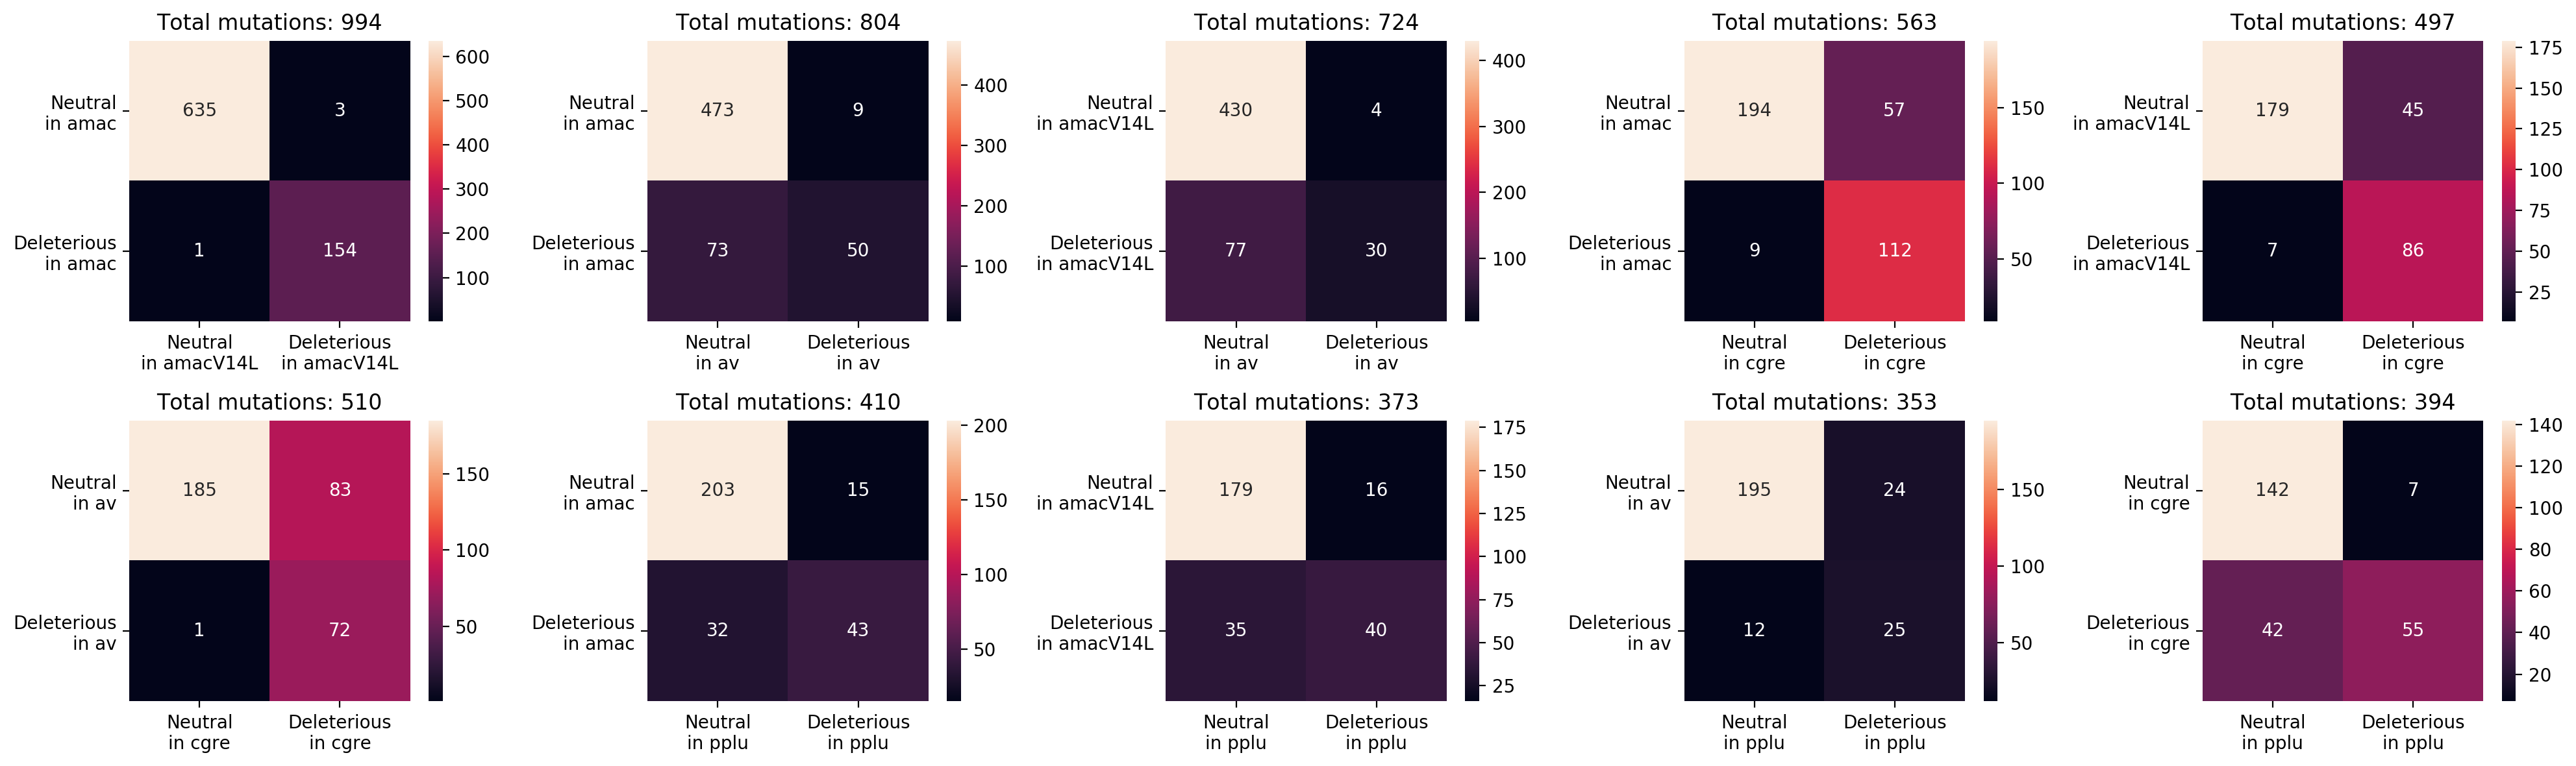

In [8]:
axes = subplots(nplots=10, nplots_per_row=5, height=3, width=4)

pairs = [('amac','amacV14L'), ('amac','av'),('amacV14L','av'),
                 ('amac','cgre'), ('amacV14L', 'cgre'), ('av','cgre'),
                 ('amac','pplu'), ('amacV14L','pplu'), ('av','pplu'), ('cgre','pplu')]

for ax,pair in zip(axes, pairs):
    plt.sca(ax)
    hm_neutrality(pair[0],pair[1],2,5)
plt.tight_layout()

In [9]:
def get_overall_fractions_cross_gene_effects(gene1, gene2, neutral_threshold, bad_threshold,
                                            normalize_total=True):

    df = df_effects_singles[['effect_in_'+gene1, 'effect_in_'+gene2]].dropna() # muts must be obsered in both genes
    df = df.reset_index()
    
    wts = {'amac' : 3.974485547944876, 'cgre' : 4.49832043653411, 'pplu' : 4.226492294827216,
          'amacV14L' : 3.9577171946556176, 'av' : 3.726358457799625}
    
    stds = {'amac' : 0.03148308406723709, 'cgre' : 0.02852658185221242, 'pplu' : 0.027489382693326424,
          'amacV14L' : 0.029670382945273337, 'av' : 0.0817635644945253}
    
    neutral_in_gene1 = df['effect_in_'+gene1] > -stds[gene1]*neutral_threshold
    neutral_in_gene2 = df['effect_in_'+gene2] > -stds[gene2]*neutral_threshold
    
    neutral_in_both_mask = (df['effect_in_'+gene1] > -stds[gene1]*neutral_threshold) & (
                                        df['effect_in_'+gene2] > -stds[gene2]*neutral_threshold)
    
    bad_in_gene1 = df['effect_in_'+gene1] < -stds[gene1]*bad_threshold
    bad_in_gene2 = df['effect_in_'+gene2] < -stds[gene2]*bad_threshold
    
    bad_in_both_mask = (df['effect_in_'+gene1] < -stds[gene1]*bad_threshold) & (
                                        df['effect_in_'+gene2] < -stds[gene2]*bad_threshold)
    
    changed_effect_mask = ((df['effect_in_'+gene1] > -stds[gene1]*neutral_threshold) & 
                            (df['effect_in_'+gene2] < -stds[gene2]*bad_threshold)) | (
                            (df['effect_in_'+gene2] > -stds[gene2]*neutral_threshold) & 
                            (df['effect_in_'+gene1] < -stds[gene1]*bad_threshold))

    if normalize_total == True:
        return {'nn' : len(df[neutral_in_both_mask]) / len(df) ,
                   'bb' : len(df[bad_in_both_mask]) / len(df), 'bn' : len(df[changed_effect_mask]) / len(df),
                   'n_muts' : len(df)}
    else:
        return {'nn' : len(df[neutral_in_both_mask]) / len(df[neutral_in_gene1 | neutral_in_gene2]) ,
                   'bb' : len(df[bad_in_both_mask]) / len(df[bad_in_gene2 | bad_in_gene1]), 
                'bn' : len(df[changed_effect_mask]) / len(df),
                   'n_muts' : len(df)}

In [10]:
def plot_effect_change(neutral_threshold, bad_threshold, mode, normalize_total=True, color=sns.cm.crest(50)):
    fractions = {}
    pairs = [('amac','amacV14L'), ('amac','av'),('amacV14L','av'),
                     ('amac','cgre'), ('amacV14L', 'cgre'), ('av','cgre'),
                     ('amac','pplu'), ('amacV14L','pplu'), ('av','pplu'), ('cgre','pplu')]
    for pair in pairs:
        fractions[pair] = get_overall_fractions_cross_gene_effects(pair[0],pair[1],
                                            neutral_threshold,bad_threshold, normalize_total=normalize_total)
        
    ylabel = {'nn' : 'Neutral/neutral', 'bb' : 'Deleterious/deleterious',
             'bn' : 'Neutral/deleterious'}
        
    spread = 1.4
    x = np.array([0, 2,3, 5,6,7, 9,10,11,12])
    plt.bar(x*spread, [100*fractions[pair][mode] for pair in pairs], width=0.8, color=color, edgecolor='k')
    plt.ylabel(f'{ylabel[mode]}\n(% of mutations)', fontsize=11)

    plt.xticks(x*spread, 
               [f'n = {fractions[pair]["n_muts"]}' for pair in pairs], 
               rotation=0, ha='center' ,  fontsize=10, va = 'top')#va='center_baseline')

    for i in range(len(pairs)):
        plt.text(x = x[i]*spread, y = 1+ 100*fractions[pairs[i]][mode], #s = fractions[pairs[i]]['n_muts'],
                 s = f'{names[pairs[i][1]]},\n{names[pairs[i][0]]}', fontsize=9,
                rotation = 0, ha='center', va='bottom')
        
    space = 100*max([fractions[x][mode] for x in fractions])/3
    plt.ylim(0,100*max([fractions[x][mode] for x in fractions])+space/1.5)

    for xi in np.array([1,4,8])*spread:
        plt.axvline(xi, linewidth=1, linestyle = ':', color='k')

    
    for xi,div in zip(np.array([0,2.5,6,10.5])*spread, 
                        ['0.4% divergence', '18% divergence', '57-59% divergence', '81-83% divergence']):
        plt.text(xi, 100*max([fractions[x][mode] for x in fractions])+space, 
                 div, horizontalalignment='center', verticalalignment='center', fontsize=12)  


Note: depending on selected thresholds, some mutations may fall in between the neutral/deleterious cutoffs.

Mutations which are neutral in one gene and deleterious in another,
out of all mutations measured in both genes.


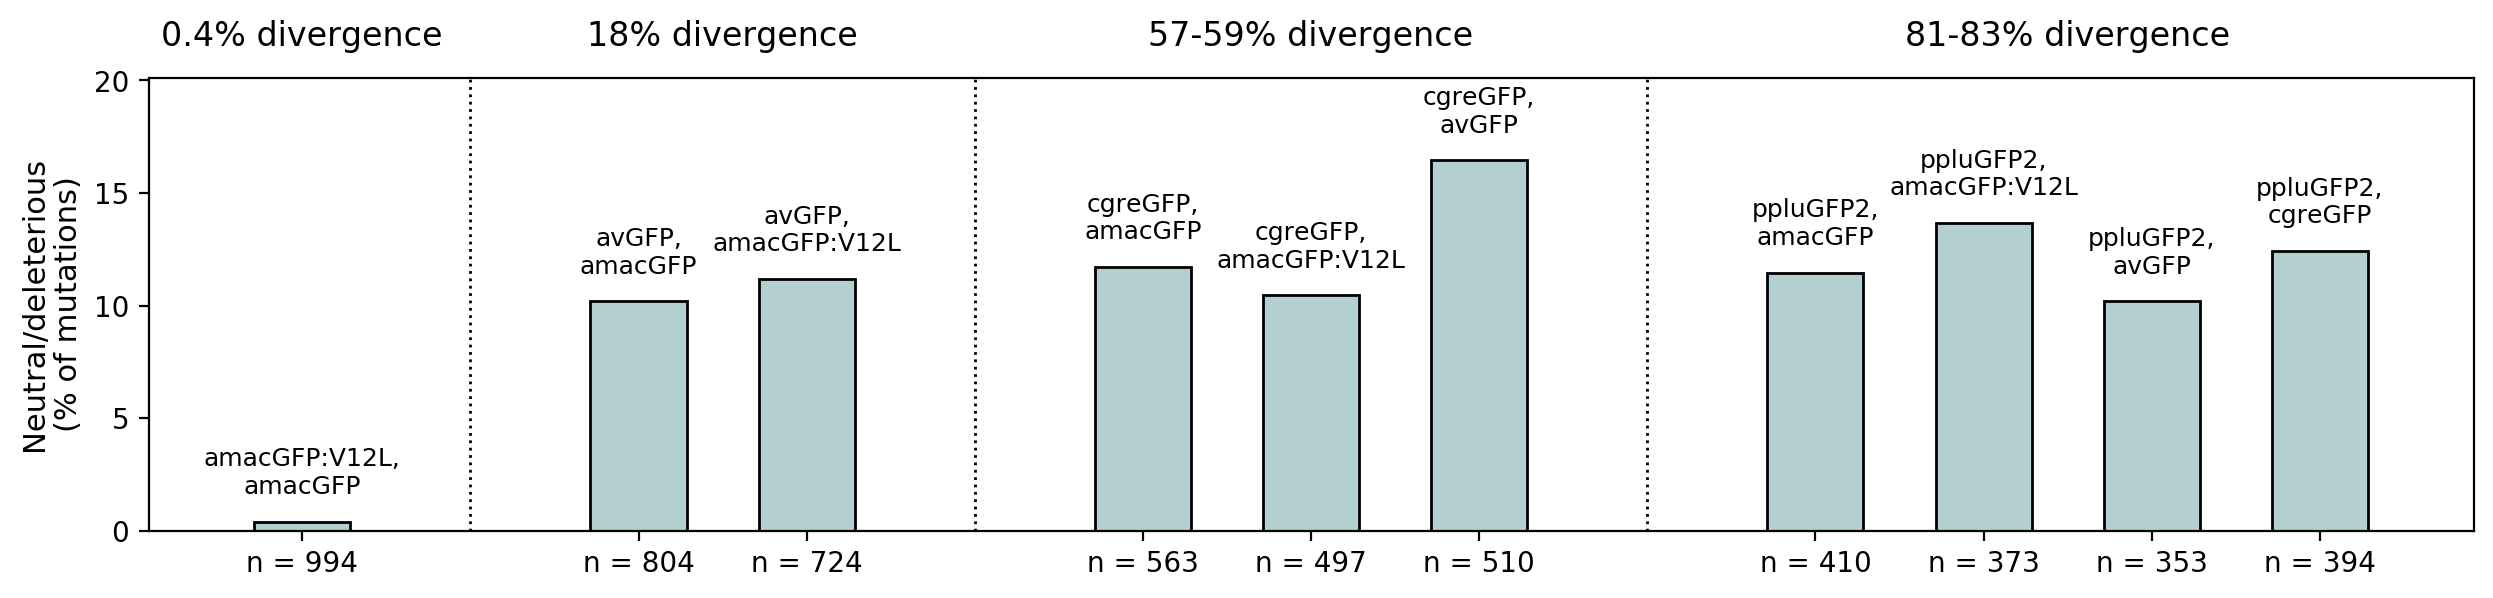

In [11]:
print('Mutations which are neutral in one gene and deleterious in another,\n\
out of all mutations measured in both genes.')

plt.figure(figsize=[15,3], dpi=200)
plot_effect_change(2,5,'bn', color=matplotlib.cm.bone(200))

Mutations which are neutral in both genes,
out of all mutations measured in both genes.



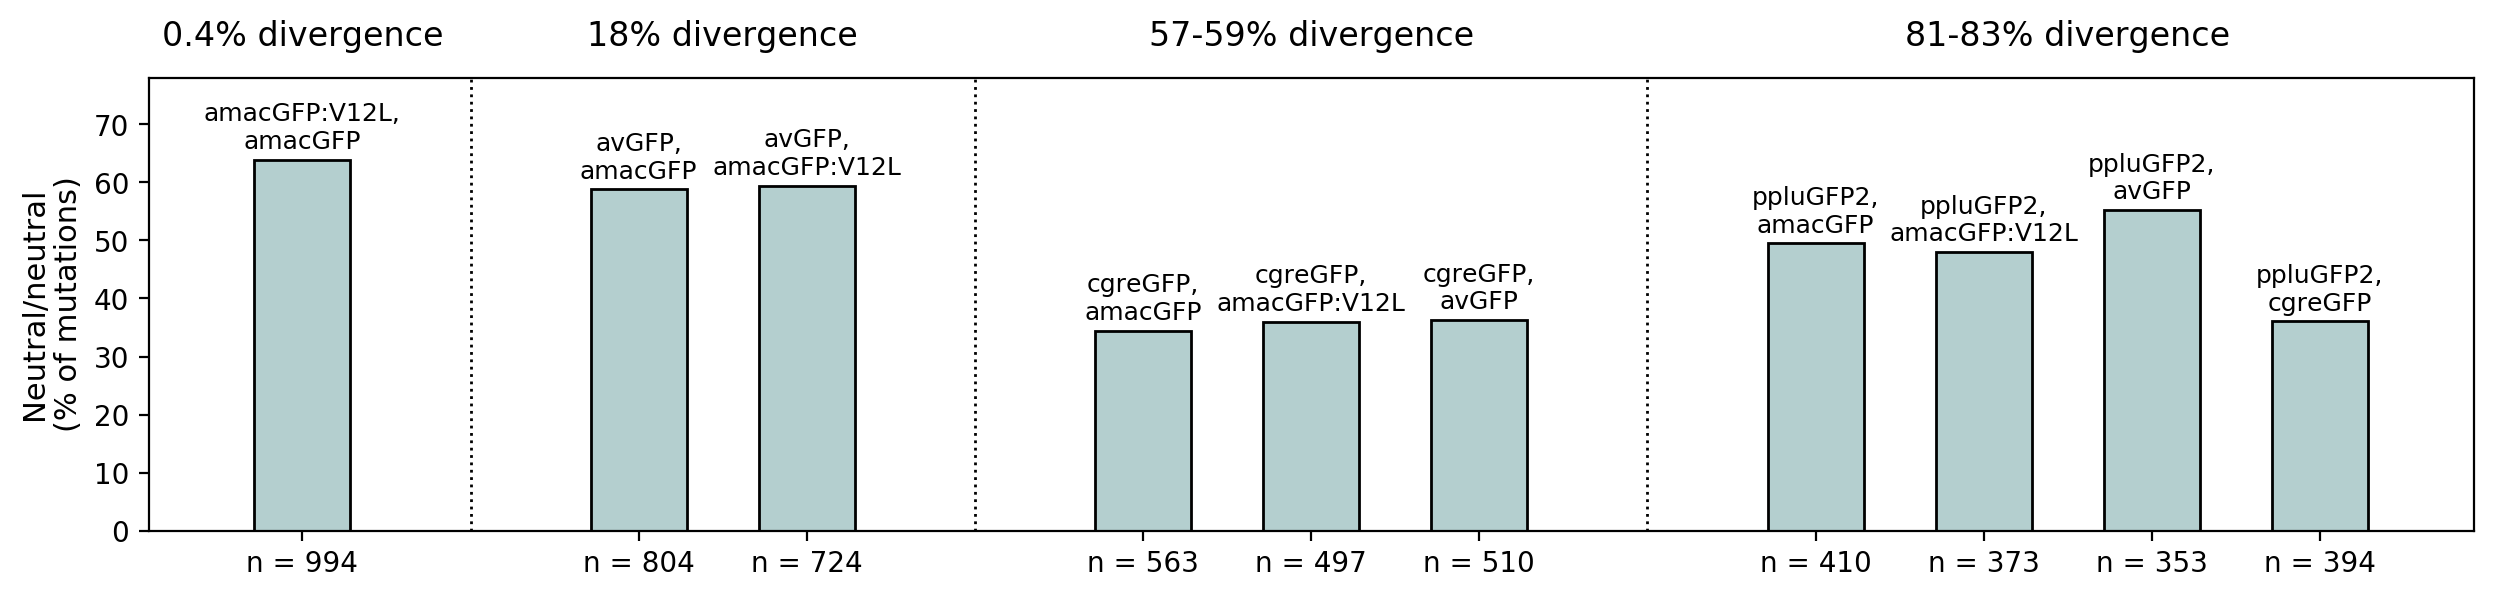

In [12]:
print('Mutations which are neutral in both genes,\n\
out of all mutations measured in both genes.\n')

plt.figure(figsize=[15,3], dpi=200)
plot_effect_change(2,5,'nn', color=matplotlib.cm.bone(200), normalize_total=True)

Mutations which are neutral in both genes,
out of all mutations which were measured in both genes AND were neutral in at least one of them.



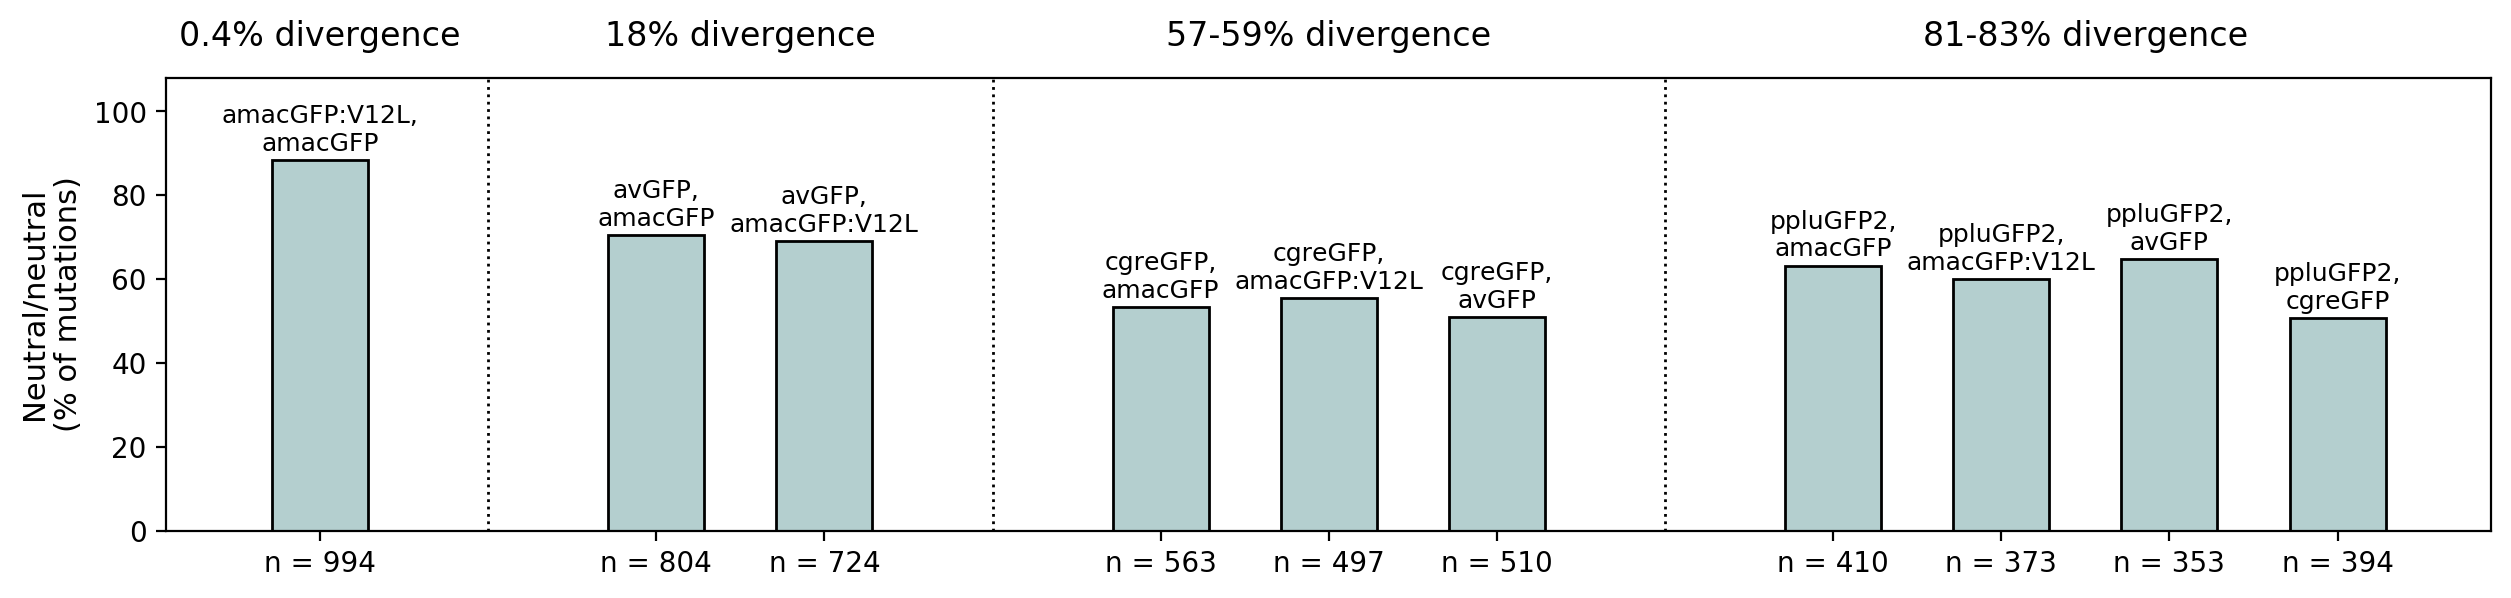

In [13]:
print('Mutations which are neutral in both genes,\n\
out of all mutations which were measured in both genes AND were neutral in at least one of them.\n')

plt.figure(figsize=[15,3], dpi=200)
plot_effect_change(2,5,'nn', color=matplotlib.cm.bone(200), normalize_total=False)

Mutations which are deleterious in both genes,
out of all mutations measured in both genes.


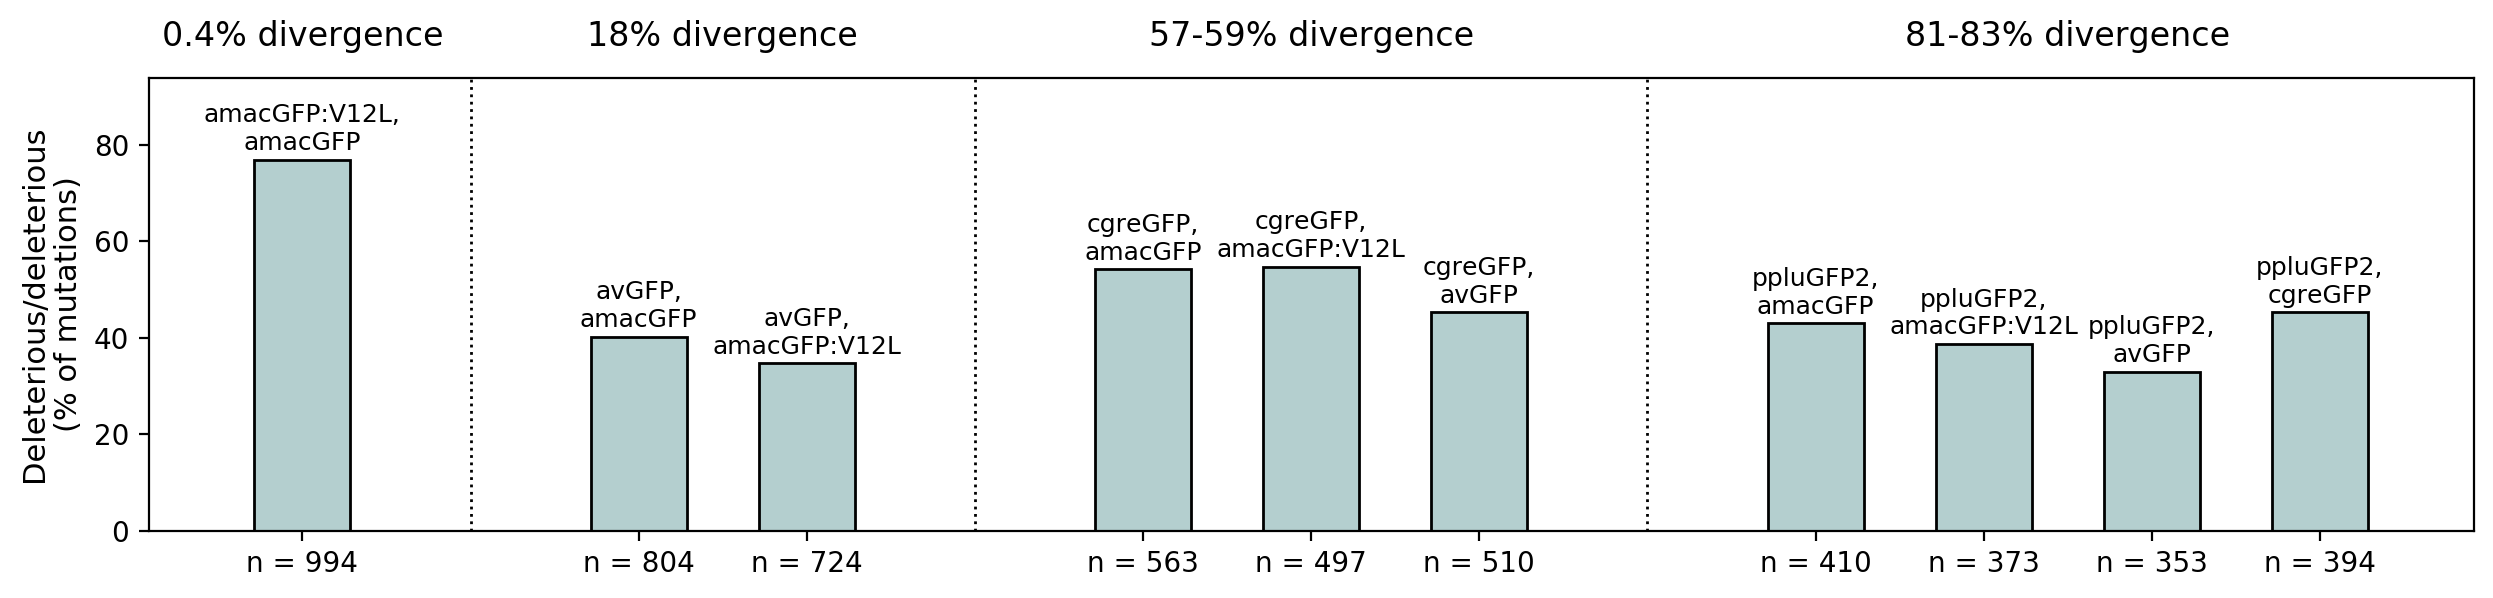

In [14]:
print('Mutations which are deleterious in both genes,\n\
out of all mutations measured in both genes.')

plt.figure(figsize=[15,3], dpi=200)
plot_effect_change(2,2,'bb', color=matplotlib.cm.bone(200), normalize_total=False)

Mutations which are neutral in both genes,
out of all mutations which were measured in both genes AND were deleterious in at least one of them.



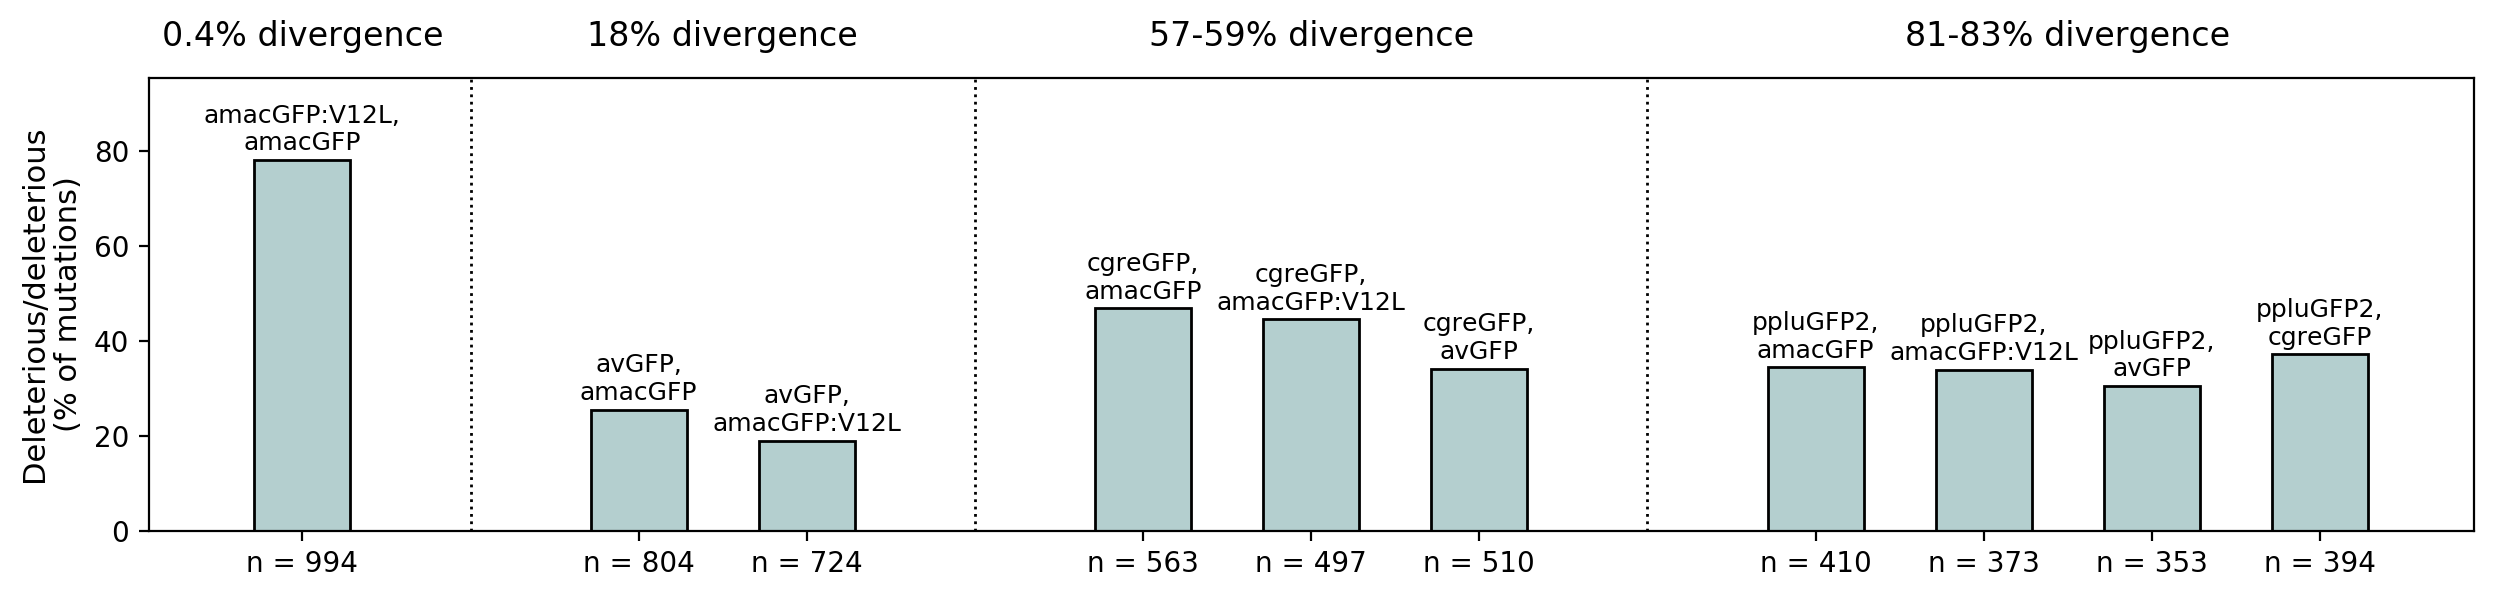

In [15]:
print('Mutations which are neutral in both genes,\n\
out of all mutations which were measured in both genes AND were deleterious in at least one of them.\n')

plt.figure(figsize=[15,3], dpi=200)
plot_effect_change(2,5,'bb', color=matplotlib.cm.bone(200), normalize_total=False)